In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, roc_auc_score

# Load dataset
cancer = load_breast_cancer()
X, y = cancer.data, cancer.target
feature_names = cancer.feature_names

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


EBM-like Model MSE: 337.5397
EBM-like Model AUC: 0.9954


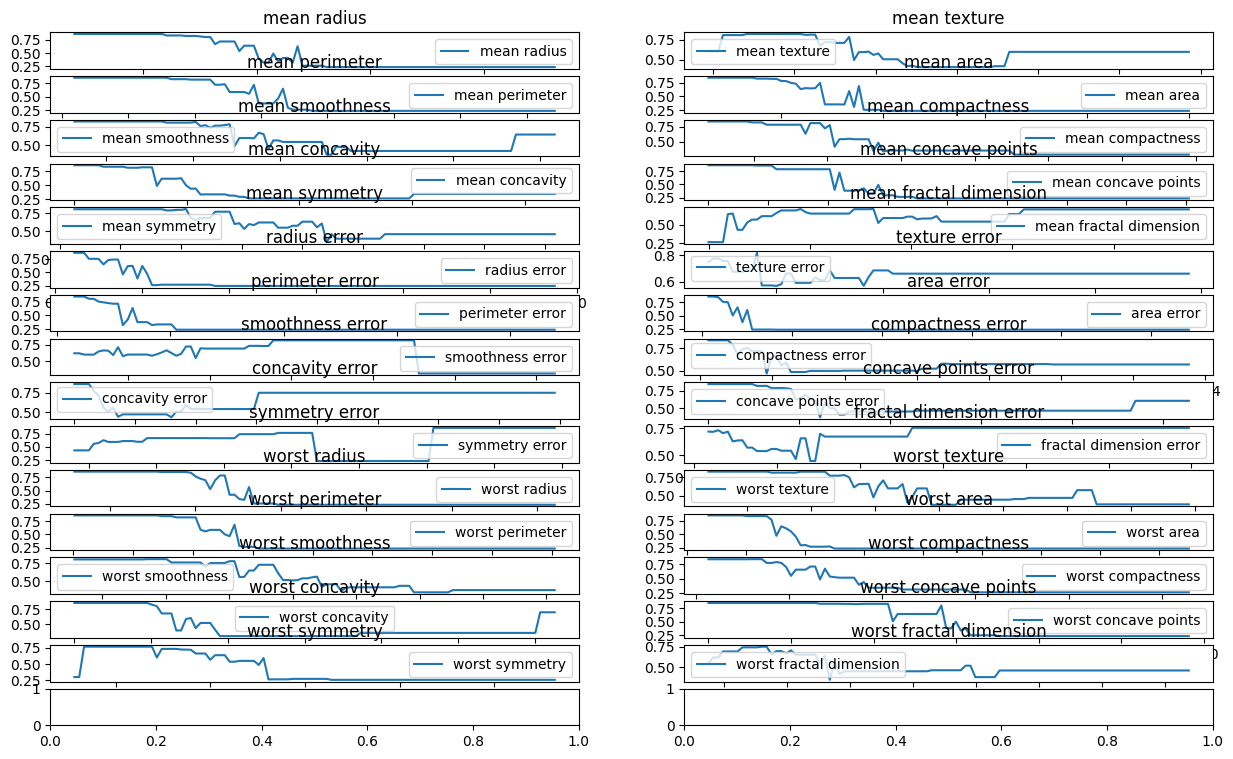

In [29]:
# Train separate boosting models for each feature
n_features = X.shape[1]
models = []
predictions_train = np.zeros_like(y_train, dtype=np.float64)
predictions_test = np.zeros_like(y_test, dtype=np.float64)

for i in range(n_features):
    model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.01, max_depth=3, random_state=42)
    model.fit(X_train[:, i].reshape(-1, 1), y_train)
    models.append(model)
    
    # Summing probability contributions of each feature
    predictions_train += model.predict_proba(X_train[:, i].reshape(-1, 1))[:, 1]
    predictions_test += model.predict_proba(X_test[:, i].reshape(-1, 1))[:, 1]

# Evaluate performance
mse = mean_squared_error(y_test, predictions_test)
auc = roc_auc_score(y_test, predictions_test)

print(f"EBM-like Model MSE: {mse:.4f}")
print(f"EBM-like Model AUC: {auc:.4f}")

# Visualize learned feature contributions
fig, axes = plt.subplots((n_features // 2) + 1, 2, figsize=(15, 9))
axes = axes.ravel()

for i, model in enumerate(models):
    x_range = np.linspace(X[:, i].min(), X[:, i].max(), 100).reshape(-1, 1)
    y_pred = model.predict_proba(x_range)[:, 1]
    axes[i].plot(x_range, y_pred, label=f"{feature_names[i]}")
    axes[i].set_title(feature_names[i])
    axes[i].legend()

# plt.tight_layout()
plt.show()

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Standardize features for Logistic Regression (ensures better convergence)
log_reg = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, random_state=42))
log_reg.fit(X_train, y_train)
log_reg_pred = log_reg.predict_proba(X_test)[:, 1]

# Decision Tree Classifier with optimized depth
tree_clf = DecisionTreeClassifier(max_depth=5, random_state=42)
tree_clf.fit(X_train, y_train)
tree_clf_pred = tree_clf.predict_proba(X_test)[:, 1]

# Evaluate performance
log_reg_auc = roc_auc_score(y_test, log_reg_pred)
tree_clf_auc = roc_auc_score(y_test, tree_clf_pred)

print(f"Logistic Regression AUC: {log_reg_auc:.4f}")
print(f"Decision Tree Classifier AUC: {tree_clf_auc:.4f}")


Logistic Regression AUC: 0.9974
Decision Tree Classifier AUC: 0.9355


/home/athyrson/.local/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


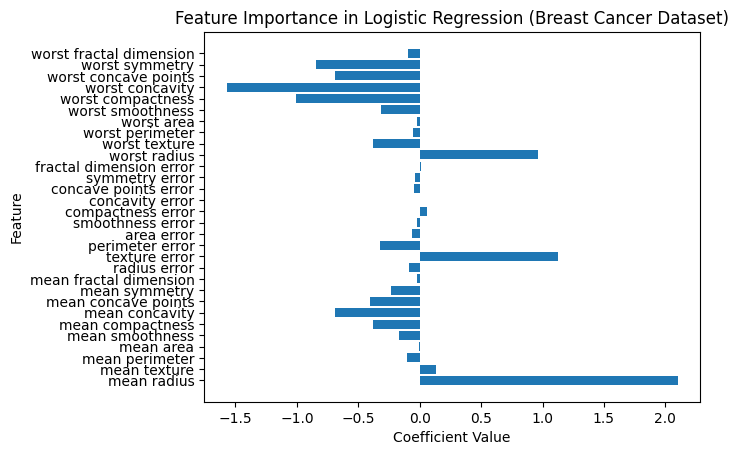

In [33]:
# Train a Logistic Regression model on the breast cancer dataset
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# Get coefficients (feature importances)
coefficients = model.coef_[0]
feature_names = cancer.feature_names

# Plot feature importances
plt.barh(feature_names, coefficients)
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.title("Feature Importance in Logistic Regression (Breast Cancer Dataset)")
plt.show()


Features in order of importance:
mean concave points: 0.0025
mean texture: 0.0025
worst concave points: 0.0018
worst texture: 0.0018
worst area: 0.0016
compactness error: 0.0016
radius error: 0.0016
area error: 0.0011
worst smoothness: 0.0004
mean concavity: 0.0002
worst compactness: 0.0000
worst concavity: 0.0000
worst symmetry: 0.0000
worst fractal dimension: 0.0000
concavity error: 0.0000
concave points error: 0.0000
symmetry error: 0.0000
fractal dimension error: 0.0000
worst radius: 0.0000
worst perimeter: 0.0000
perimeter error: 0.0000
smoothness error: 0.0000
mean symmetry: 0.0000
mean fractal dimension: 0.0000
texture error: 0.0000
mean compactness: 0.0000
mean smoothness: 0.0000
mean area: 0.0000
mean perimeter: 0.0000
mean radius: 0.0000


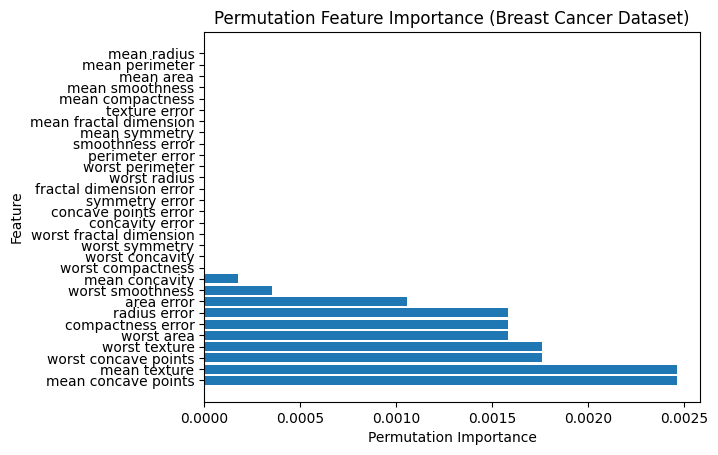

In [36]:
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# Use the breast cancer dataset
X = cancer.data
y = cancer.target

# Train a Random Forest model
model = RandomForestClassifier(random_state=42)
model.fit(X, y)

# Calculate permutation importance
result = permutation_importance(model, X, y, n_repeats=10, random_state=42)

# Get feature importances
importances = result.importances_mean
feature_names = cancer.feature_names

# Sort features by importance
sorted_indices = np.argsort(importances)[::-1]
sorted_features = feature_names[sorted_indices]
sorted_importances = importances[sorted_indices]

# Print features in order of importance
print("Features in order of importance:")
for feature, importance in zip(sorted_features, sorted_importances):
    print(f"{feature}: {importance:.4f}")

# Plot feature importances
plt.barh(sorted_features, sorted_importances)
plt.xlabel("Permutation Importance")
plt.ylabel("Feature")
plt.title("Permutation Feature Importance (Breast Cancer Dataset)")
plt.show()


In [40]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline

# Select the 7 most important features according to Pearson's correlation
selector = SelectKBest(f_classif, k=1)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Train separate boosting models for each selected feature
n_selected_features = X_train_selected.shape[1]
models_selected = []
predictions_train_selected = np.zeros_like(y_train, dtype=np.float64)
predictions_test_selected = np.zeros_like(y_test, dtype=np.float64)

for i in range(n_selected_features):
    model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.01, max_depth=3, random_state=42)
    model.fit(X_train_selected[:, i].reshape(-1, 1), y_train)
    models_selected.append(model)
    
    # Summing probability contributions of each feature
    predictions_train_selected += model.predict_proba(X_train_selected[:, i].reshape(-1, 1))[:, 1]
    predictions_test_selected += model.predict_proba(X_test_selected[:, i].reshape(-1, 1))[:, 1]


auc_selected = roc_auc_score(y_test, predictions_test_selected)


print(f"EBM-like Model with Selected Features AUC: {auc_selected:.4f}")

# Train benchmark models with selected features
# Logistic Regression
log_reg_selected = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, random_state=42))
log_reg_selected.fit(X_train_selected, y_train)
log_reg_pred_selected = log_reg_selected.predict_proba(X_test_selected)[:, 1]

# Decision Tree Classifier
tree_clf_selected = DecisionTreeClassifier(max_depth=5, random_state=42)
tree_clf_selected.fit(X_train_selected, y_train)
tree_clf_pred_selected = tree_clf_selected.predict_proba(X_test_selected)[:, 1]

# Evaluate performance of benchmark models
log_reg_auc_selected = roc_auc_score(y_test, log_reg_pred_selected)
tree_clf_auc_selected = roc_auc_score(y_test, tree_clf_pred_selected)

print(f"Logistic Regression with Selected Features AUC: {log_reg_auc_selected:.4f}")
print(f"Decision Tree Classifier with Selected Features AUC: {tree_clf_auc_selected:.4f}")

EBM-like Model with Selected Features AUC: 0.9707
Logistic Regression with Selected Features AUC: 0.9784
Decision Tree Classifier with Selected Features AUC: 0.9229


In [ ]:
y_test.shape

(114,)

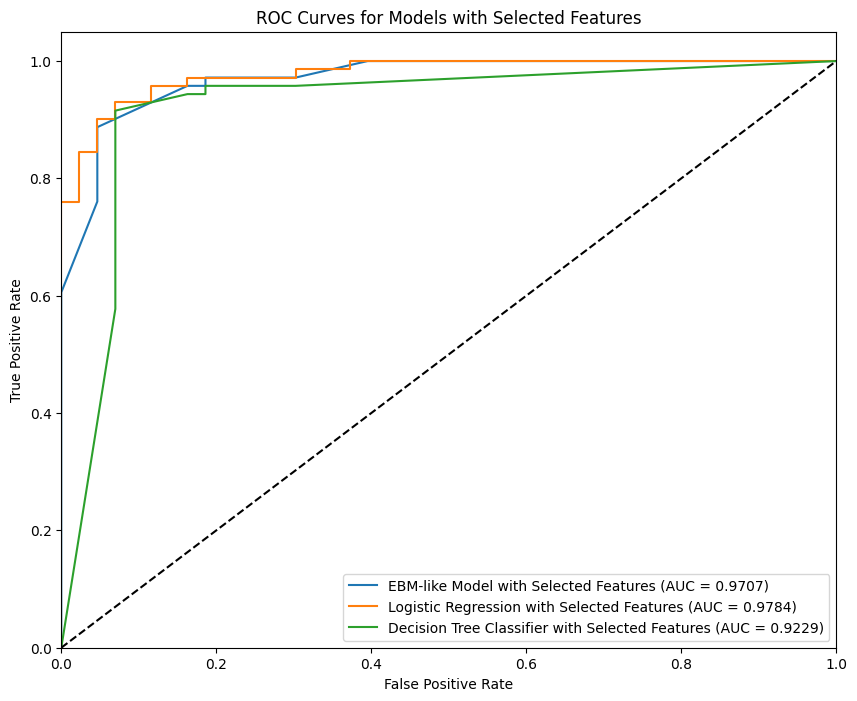

In [42]:
from sklearn.metrics import roc_curve, auc

# Calculate ROC curves
fpr_ebm_selected, tpr_ebm_selected, _ = roc_curve(y_test, predictions_test_selected)
fpr_log_reg_selected, tpr_log_reg_selected, _ = roc_curve(y_test, log_reg_pred_selected)
fpr_tree_clf_selected, tpr_tree_clf_selected, _ = roc_curve(y_test, tree_clf_pred_selected)

# Calculate AUC values
auc_ebm_selected = auc(fpr_ebm_selected, tpr_ebm_selected)
auc_log_reg_selected = auc(fpr_log_reg_selected, tpr_log_reg_selected)
auc_tree_clf_selected = auc(fpr_tree_clf_selected, tpr_tree_clf_selected)

# Plot ROC curves
plt.figure(figsize=(10, 8))
plt.plot(fpr_ebm_selected, tpr_ebm_selected, label=f'EBM-like Model with Selected Features (AUC = {auc_ebm_selected:.4f})')
plt.plot(fpr_log_reg_selected, tpr_log_reg_selected, label=f'Logistic Regression with Selected Features (AUC = {auc_log_reg_selected:.4f})')
plt.plot(fpr_tree_clf_selected, tpr_tree_clf_selected, label=f'Decision Tree Classifier with Selected Features (AUC = {auc_tree_clf_selected:.4f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Models with Selected Features')
plt.legend(loc='lower right')
plt.show()
